# Text Classification - Sentiment Analysis

One of the common uses for binary classification in machine learning is analyzing text for sentiment — specifically, assigning a text string a score from 0 to 1, where 0 represents negative sentiment and 1 represents positive sentiment. A restaurant review such as "Best meal I've ever had and awesome service, too!" might score 0.9, while a statement such as "Long lines and poor customer service" might score 0.1. Marketing departments sometimes use sentiment-anlysis models to monitor social-media services for feedback so they can respond quickly if, for example, comments regarding their company suddenly turn negative.

To train a sentiment-analysis model, you need a dataset containing text strings labeled with 0s (for negative sentiment) and 1s (for positive sentiment). Several such datasets are available in the public domain. We will use one containing 50,000 movie reviews, each labeled with a 0 or 1. Once the model is trained, scoring a text string for sentiment is a simple matter of passing it to the model and asking for the probability that the predicted label is 1. A probability of 80% means the sentiment score is 0.8 and that the text is very positive.

## Load and prepare the data

The first step is to load the dataset and prepare it for use in machine learning. Because machine-learning models can't deal with text, we'll use scikit-learn's [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) class to vectorize the training text. Then we'll split the data for training and testing.

In [18]:
import pandas as pd
 
df = pd.read_csv('Data/reviews.csv', encoding='ISO-8859-1')
df.head()

,Text,Sentiment
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


Find out how many rows the dataset contains and confirm that there are no missing values.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       50000 non-null  object
 1   Sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


Check for duplicate rows in the dataset.

In [20]:
df.groupby('Sentiment').describe()

Text                                                            \
           count unique                                                top   
Sentiment                                                                    
0          25000  24697  When i got this movie free from my job, along ...   
1          25000  24884  Loved today's show!!! It was a variety and not...   

                
          freq  
Sentiment       
0            3  
1            5

The dataset contains a few hundred duplicate rows. Let's remove them and check for balance.

In [21]:
df = df.drop_duplicates()
df.groupby('Sentiment').describe()

Text                                                            \
           count unique                                                top   
Sentiment                                                                    
0          24697  24697  Once again Mr. Costner has dragged out a movie...   
1          24884  24884  I went and saw this movie last night after bei...   

                
          freq  
Sentiment       
0            1  
1            1

Use [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to vectorize the text in the DataFrame's "Text" column using a built-in dictionary of stop words. Set `min_df` to 20 to ignore words that appear less than 20 times in the corpus of training text. This will reduce the likelihood of out-of-memory errors and will probably make the model more accurate as well. Also use the `ngram_range` parameter to allow `CountVectorizer` to rank word pairs as well as individual words.

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer is like a “word counter” that will turn text into numbers that a computer can understand.
# ngram_range=(1, 2) → Look at single words (unigrams) and pairs of words (bigrams).
# Example: “quick brown fox” → “quick”, “brown”, “fox”, “quick brown”, “brown fox”
# stop_words='english' → Ignore common words like the, and, is, because they don’t help.
# min_df=20 → Ignore words that appear in less than 20 documents, so tiny rare words don’t clutter things up.

vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english', min_df=20)
x = vectorizer.fit_transform(df['Text'])
y = df['Sentiment']

In addition to creating sparse matrices of vectorized text, `Countvectorizer` converts text to lowercase, removes stop words and punctuation characters, and more. Let's see how it cleans text before vectorizing it by transforming a string, and then reversing the transform.

In [10]:
text = vectorizer.transform(['The long l3ines   and; pOOr customer# service really turned me off...123.'])
text = vectorizer.inverse_transform(text)
print(text)

[array(['customer', 'long', 'poor', 'really', 'service', 'turned'],
      dtype='<U25')]


Split the dataset for training and testing. We'll do a 50/50 split since the dataset contains nearly 50,000 samples.

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)  

## Train a logistic-regression model

The next step is to train a classifier. We'll use scikit-learn's [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier, which uses [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) to fit a model to the data.

In [13]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, random_state=0)
model.fit(x_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,0
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


Validate the trained model with the 50% of the dataset aside for testing and show a confusion matrix.

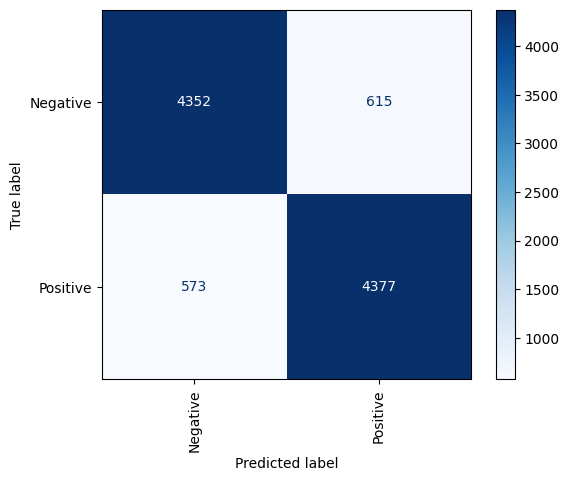

In [15]:
%matplotlib inline
from sklearn.metrics import ConfusionMatrixDisplay as cmd

cmd.from_estimator(model, x_test, y_test,
                   display_labels=['Negative', 'Positive'],
                   cmap='Blues', xticks_rotation='vertical')

<!-- The model correctly identified 10,795 negative reviews while misclassifying 1,574 of them. It correctly identified 10,966 positive reviews and got it wrong 1,456 times. -->

The model correctly identified 4352 negative reviews while misclassifying 573 of them. It correctly identified 4377 positive reviews and got it wrong 615 times.

## Use the model to analyze text

Let's score a review by vectorizing the text of that review and passing it to the model's `predict_proba` method. Are the results consistent with what you would expect?

In [16]:
review = 'The long lines and poor customer service really turned me off.'
model.predict_proba(vectorizer.transform([review]))[0][1]

np.float64(0.15550137891447702)

Now score a more positive review and see if the model agrees that the sentiment is positive.

In [17]:
review = 'The food was great and the service was excellent!'
model.predict_proba(vectorizer.transform([review]))[0][1]

np.float64(0.8816277276387118)

Feel free to try sentences of your own and see if you agree with the sentiment scores the model predicts. It’s not perfect, but it’s good enough that if you run hundreds of reviews or comments through it, you should get a reliable indication of the positivity or negativity expressed in the text.